# Tutorial

This tutorial shows the basic steps of using CyMorph to extract metrics from an image.

First we need to load a `fit` image. 

In [2]:
# additional libraries for data loading and manipulation
import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10., 8.]


# image is from SDSS DR7 (objid=587725472806600764)
fits_file = fits.open('data/image.fits')
# all data arrays should be np.float32
image = np.array(fits_file[0].data, np.float32)

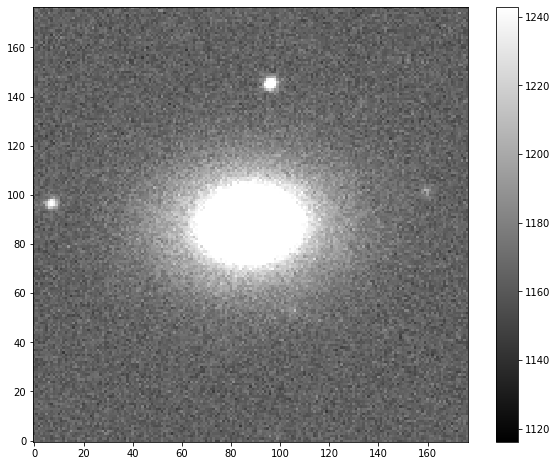

In [3]:
# show the image
m, s = np.mean(image), np.std(image)
plt.imshow(image, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();

It is essential to point out that this image should be preprocessed (as it contains secondary sources):

1. Cleaned - remove secondary objects
2. Recenter - barycenter of the target object should match the central pixel of the image.
3. A segmented mask should be applied to assign 0 value for all the pixels that do not belong to the target object.
 
All these routines are not included in CyMorph code and are the end-users responsibility. It is dictated by the fact that each survey is different in optics, resolution, and storage routines (sky subtraction, object identification, or even cleaning).
 
Here we will present an example of basic methods to perform these steps. All steps heavily rely on the `sep` package and its methods.

### Object detection

In [4]:
import sep

# background estimation
bkg = sep.Background(image)
# background subtraction
image_sub = image - bkg
# source detection
detection_threshold = 1.5
objects, segmented_mask = sep.extract(image_sub, detection_threshold, err=bkg.globalrms, segmentation_map=True)

It is important to point out that we need to pass `segmentation_map=True` to receive a segmented map (mask) from `sep.extract`.

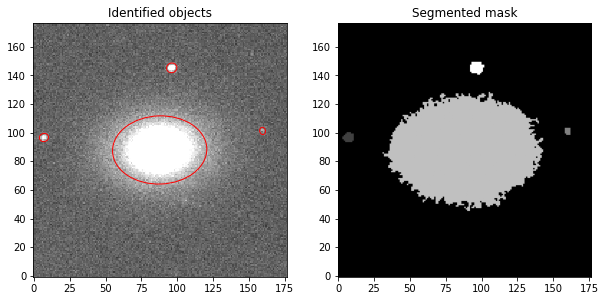

In [5]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots(1, 2)
m, s = np.mean(image_sub), np.std(image_sub)
ax[0].set_title('Identified objects')
im = ax[0].imshow(image_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=4*objects['a'][i],
                height=4*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax[0].add_artist(e)

# plot segmented mask for comparison
ax[1].set_title('Segmented mask')
ax[1].imshow(segmented_mask, origin='lower', cmap='gray') 

### Target object identification

Input image should contain the target object in the center, so to identify it, locate the object that is the nearest to the central pixel of the image. This will yield only the target object from an array of all detected objects.

In [6]:
dx = (objects['x'] - (len(image_sub)/2))**2
dy = (objects['y'] - (len(image_sub)/2))**2
    
distance = np.sqrt(dx + dy)
# this will return only target object    
main_object = objects[distance == min(distance)]

In [7]:
# we need to find index of the target object, to identify it on the segmented mask
# each object on the segmented mask is filled with values index+1
main_object_index, = np.where(objects['x'] == main_object['x'])
main_object_index = int(main_object_index) + 1

### Cleaning the image

Several metrics require a clean image to produce the result. Secondary sources will hinder the quality of the extracted morphometry.

In [8]:
# clean_mask is different from segmented mask, is a sense that all pixels have values equal to 1
# and secondary sources have values as 0
clean_mask = np.copy(segmented_mask)

# assign 0 to main object pixels
clean_mask[clean_mask==main_object_index] = 0
# everything that is not 0 (only pixels that belong to secondary objects) will receive 1
clean_mask[clean_mask!=0] = 1
# invert the matrix
clean_mask=1-clean_mask

In [9]:
# apply clean mask on image
clean_image = image * clean_mask

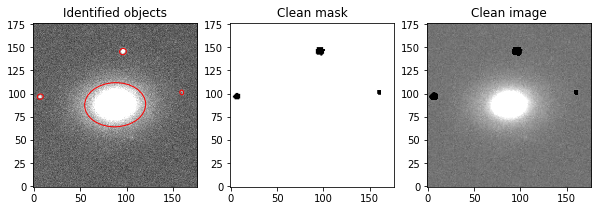

In [10]:
# plot background-subtracted image
fig, ax = plt.subplots(1, 3)
m, s = np.mean(image_sub), np.std(image_sub)
ax[0].set_title('Identified objects')
im = ax[0].imshow(image_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=4*objects['a'][i],
                height=4*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax[0].add_artist(e)

ax[1].set_title('Clean mask')
ax[1].imshow(clean_mask, origin='lower', cmap='gray') 

ax[2].set_title('Clean image')
m, s = np.mean(clean_image), np.std(clean_image)
ax[2].imshow(clean_image, origin='lower', cmap='gray',vmin=m-s, vmax=m+s) 

To maintain coherence with the rest of the background, it is necessary to fill these patches with matching pixel values. `sep` provides `bkg.globalback` and `bkg.globalrms`. That is a "global" mean and noise of the image background respectively.

In [11]:
# getting all the pixels belonging to secondary objects (they are all equal to 0)
x,y = np.where(clean_image==0)

# applying random values drawn from normal distribution
mu, sigma = bkg.globalback, bkg.globalrms
for key,value in enumerate(x):
    clean_image[x[key],y[key]] =  np.random.normal(mu, sigma, 1)

This will produce images with masked secondary objects and minimize the influence of the pixel variation for the metrics extraction.

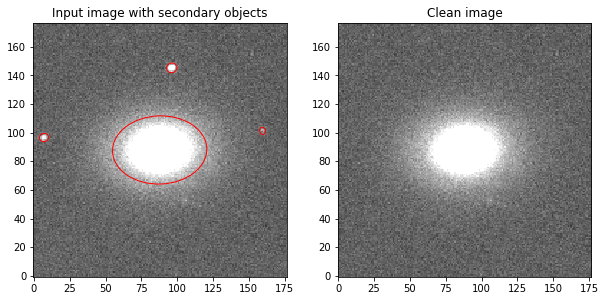

In [12]:
# plot background-subtracted image
fig, ax = plt.subplots(1, 2)
m, s = np.mean(image_sub), np.std(image_sub)
ax[0].set_title('Input image with secondary objects')
im = ax[0].imshow(image_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=4*objects['a'][i],
                height=4*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax[0].add_artist(e)

m, s = np.mean(clean_image), np.std(clean_image)
ax[1].set_title('Clean image')
im = ax[1].imshow(clean_image, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

### Image recentering

Multiple metrics rely on two caracteristics of the image:
 - Image should have odd shape
 - The central pixel should match the central pixel of the target object

In [16]:
# getting image center
from math import floor
height, width = clean_image.shape
center_x, center_y = floor(height/2), floor(width/2)
print(f'Height = {height}, Width = {width}')
print(f'Center x = {center_x}, Center y = {center_y}')

Height = 177, Width = 177
Center x = 88, Center y = 88


In [25]:
# getting target object center
object_center_x, object_center_y = round(main_object['x'].item()), round(main_object['y'].item())
print(f'Object center x = {object_center_x}, Object center y = {object_center_y}')

Object center x = 88, Object center y = 88


In [27]:
# comparing image center and object center
center_x == object_center_x and center_y == object_center_y

True

In this case, the image center matches the central pixel of the object, so no additional actions are necessary.

### Segmenting image (isolating target object)

The difference between `clean_image` and `segented_image` consists in the fact that `clean_image` contains flux counts in all pixels around the target object. In the case of `segented_image`, all pixels that do not belong to the target object will be set to 0.

In [12]:
# assign 0 to all pixels that do not belong to target object
segmented_mask[segmented_mask!=main_object_index] = 0

In [13]:
# applying mask on the input image
segmented_image = image * segmented_mask

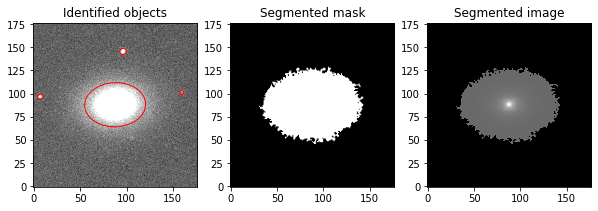

In [14]:
fig, ax = plt.subplots(1, 3)
m, s = np.mean(image_sub), np.std(image_sub)
ax[0].set_title('Identified objects')
im = ax[0].imshow(image_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=4*objects['a'][i],
                height=4*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax[0].add_artist(e)

ax[1].set_title('Segmented mask')
ax[1].imshow(segmented_mask, origin='lower',cmap='gray') 

ax[2].set_title('Segmented image')
m, s = np.mean(image_sub), np.std(image_sub)
ax[2].imshow(segmented_image, interpolation='nearest', cmap='gray',
              origin='lower')

In [15]:
# converting all the necessary images to np.float32
clean_image = np.array(clean_image, dtype=np.float32)
segmented_image = np.array(segmented_image, dtype=np.float32)
segmented_mask = np.array(segmented_mask, dtype=np.float32)

## Exatracting metrics

Basic showcase of extracting metrics. For additional details see corresponding sections.

### Concentration (C)

In [16]:
# importing class
from cymorph.concentration import Concentration

# values for two radii of the flux concentration 
radius1 = 0.8
radius2 = 0.2

# create concentration object 
c = Concentration(clean_image, radius1, radius2)
# retrieve the concentration value

print(f'Concentration metric = {c.get_concentration()}')

Concentration metric = 0.6648536110782144


### Asymmetry (A) 

In [17]:
# importing class
from cymorph.asymmetry import Asymmetry

# creating object
a = Asymmetry(segmented_image) 

# asymmetry contains two coeficients of correlation
print(f'Asymmetry (pearson) metric = {a.get_pearsonr()}')
print(f'Asymmetry (spearman) metric = {a.get_spearmanr()}')

Asymmetry (pearson) metric = 0.011054729880220271
Asymmetry (spearman) metric = 0.1103719041925253


### Smoothness (S)

In [18]:
# importing the class
from cymorph.smoothness import Smoothness

# parameters of image smoothing
butterworth_order = 2
smoothing_degradation = 0.2

# creating the object
s = Smoothness(clean_image, segmented_mask, smoothing_degradation, butterworth_order) 

# smoothness contains two coeficients of correlation
print(f'Smoothness (pearson) metric = {s.get_pearsonr()}')
print(f'Smoothness (spearman) metric = {s.get_spearmanr()}')

Smoothness (pearson) metric = 0.009534401350611121
Smoothness (spearman) metric = 0.06244495997183619


### Entropy (H)

In [19]:
# importing the class
from cymorph.entropy import Entropy

# entropy bins parameters
bins = 130

# creating the object
e = Entropy(segmented_image, bins)

# retrieving the metric
print(f'Entropy metric = {e.get_entropy()}')

Entropy metric = 0.49624255299568176


### Gradient Pattern Analysis (G2)

In [20]:
# importing the class
from cymorph.g2 import G2

# setting the tolerances
g2_modular_tolerance               = 0.03
g2_phase_tolerance                 = 0.02

# creating g2 object
g2 = G2(segmented_image, g2_modular_tolerance, g2_phase_tolerance)

# retriving the metric
print(f'G2 metric = {g2.get_g2()}')

G2 metric = 0.5578498244285583
